In [41]:
import csv
import math
def areawise(freqfile,percentfile):
    csvfile = open(percentfile, newline='')
    csvAvg = open(freqfile,newline='')
    
    c = csv.reader(csvfile)
    d = csv.reader(csvAvg)
    months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    average=[0] * 71  # change to higher value to make it non-redundant for now it is equal to the no of total unique crimes
    i=0
    yearsToTrain = 13    # change s value to no of years to be used for training 
    
    for row in d:
        if row[0] == 'TOTAL'or row[0]=='Category' or row[0]=='year' or row[0]=='month':
            continue
        else:
           j=0
           for month in range (1,(yearsToTrain*12)+1):
               if float(row[month]) !=0:    
                   j+=1
                   average[i] += float(row[month])    # maintain grand average for scale later 
           if average[i] != 0:
                average[i] /= j
           i+=1
          
    percentages = []
    totals = []
    categories =[]
    i = 0
    monYear = []
    
    for row in c:
        
        if row[0] == 'TOTAL'or row[0]=='Category' or row[0]=='year':
            continue
        elif row[0]=='month':
            for month in range(1,(yearsToTrain*12)+1):
                monYear.append(float(row[month]))
        else:
           temp = []
           categories.append(row[0])
           
           for month in range (1,(yearsToTrain*12)+1):
               if float(row[month]) !=0:    
                   j+=1
               
               temp.append(float(row[month]))   # add monthly percentages of a particular crime to  list 
           
           percentages.append(temp)   # add monthly percentages list to a list 
           i += 1
    
    predictions=[]

    i=1 # change this to get result of all crimes 
    def predictOverYears(start,end):           # fn to give prediction for one year mentioned by start and end
        predictAyear = []
        for idx in range (0,i):
            crime = percentages[idx]
            sum =0
            index = -1
            for it in range (start,end):     # sum for caluclationg confidence later on             
                sum+=crime[it]
        
            predictMonth = []
    
            for it in range (start,end):
                avg = sum - crime[it]
                avg=float(avg/11)
                if avg != 0:
                    likeness = ((float(crime[it])/(avg))) * 100    # measure confidence rate for that month for that crime
                else :
                    likeness=0
                temp = [likeness,monYear[it]]
                predictMonth.append(temp)                   # append confidence rate and index of month predicted
    
            predictAyear.append(predictMonth)           # append all month's of that year likliness to a list 
        return predictAyear


    for j in range(0,yearsToTrain):            
        n=j*12
        predictions.append(predictOverYears(n,n+12))
    
    # print(predictions[1])
    
    predictionPerCrime = []
    for idx in range(0,i):
        tem = []
        for k in range(0,yearsToTrain):
            tem.append(predictions[k][idx])           # get each individual year predictions and add it to a new list 
        predictionPerCrime.append(tem)
        
    # print(predictionPerCrime[0])


    # alpha = 0.25
    # beta = 0.5
    alpha = 0.25
    beta = 0.25


    grandPrediction = []
    for idx in range(0,i):
        perCrimeConf=[]
        for month in range(0,12):
            sumOverYears=0
            estCF = 0
            devCF = 0
            for yr in range(0,yearsToTrain): 
                  yearCf = predictionPerCrime[idx][yr][month][0]
                #   print("yearCf of ",month," ",yr,":",yearCf)
                  if(yr==0):
                      estCf=yearCf
                      devCf=yearCf
                  estCf = (1-alpha)*estCf + alpha*yearCf
                #   devCf = (1-beta)*devCf + beta*(math.fabs(estCf-yearCf))
                  devCf = (1-beta)*devCf + beta*(estCf-yearCf)
                  print("yearCf of ",month," ",yr,":",estCf-(4*devCf))
                #   print("yearCf of ",month," ",yr,":",estCf)
                     
                # sumOverYears+=predictionPerCrime[idx][yr][month][0]   # ***** changes to happen here *******
            # tem=sumOverYears/yearsToTrain   # sum of confidence of a month across years and divide by yearsToTrain
            tem=estCf - (4*devCf)
            # tem=estCf
            perCrimeConf.append((tem))
        grandPrediction.append(perCrimeConf)  # append confidence rates of each month per crime to list 

    
    
    # print(grandPrediction[0][2])
    
    for j in range(0,i):
        low=9999
        for m in range(0,12):
            if grandPrediction[j][m] < low:
                low = grandPrediction[j][m]
        if low != 0 :
             low = math.ceil(low) -2  # find lowest value ceil it and subtrat 2 from it
        for n in range(0,12):
            grandPrediction[j][n] -= low  # then subtract this val(low) from all
    
    print("{")
    # print('\"'+freqfile.split('_')[0]+'\":')
    # print("[")
    


    for j in range(0,i):
        
        print('\"'+categories[j]+'\":')
        print('[')
        print('{')
        
        max = 0
        avg = 0
        for m in range (0,12):
             avg+=grandPrediction[j][m]
             if grandPrediction[j][m] > max :
                 max = grandPrediction[j][m]
        avg=avg/12
        ideal = ( max + avg)/2     # compute ideal confidence and acceptable confidence level
        print('\"'+"overallAverage"+'\":'+str(average[j])+',')
        print('\"'+"idealConfidence"+'\":'+str(ideal)+',')
        print('\"'+"accepatableConfidence"+'\":'+str(avg)+',')
        print('\"'+"confidenceRates"+'\":'+'[')
        print('{')
        for k in range(0,12):
            if k != 11:
                print('\"'+months[k]+'\":'+str((grandPrediction[j][k]/ideal)*average[j])+"   cf:  "+str(grandPrediction[j][k])+',')
            else:
                print('\"'+months[k]+'\":'+str((grandPrediction[j][k]/ideal)*average[j])+"   cf:  "+str(grandPrediction[j][k]))
        # print(j+1,")",categories[j],"With overall average:",average[j])
        # print("With ideal confidence:",ideal,"and acceptable confidence:",avg,"monthly predictons are:")
        # for k in range(0,12):
        #     print("     Month",k+1,"confidence rate:",grandPrediction[j][k]) 
        print('}')  
        print(']')
        if j!=i-1:
            print('}],')
        else:
            print('}]')
                 
    # print(']')
    print('}')

# areawise('BRONX_Frequency.csv','BRONX_PercentageTotal.csv')
# areawise('BROOKLYN_Frequency.csv','BROOKLYN_PercentageTotal.csv')
# areawise('MANHATTAN_Frequency.csv','MANHATTAN_PercentageTotal.csv')
# areawise('QUEENS_Frequency.csv','QUEENS_PercentageTotal.csv')
areawise('STATEN_ISLAND_Frequency.csv','STATEN_ISLAND_PercentageTotal.csv')



yearCf of  0   0 : -188.2276828258808
yearCf of  0   1 : -114.40892149821602
yearCf of  0   2 : -79.39222454790942
yearCf of  0   3 : -36.901734016032094
yearCf of  0   4 : -15.413942072224955
yearCf of  0   5 : 15.300406240941328
yearCf of  0   6 : 26.498315143790016
yearCf of  0   7 : 58.729069970162854
yearCf of  0   8 : 56.16372188164759
yearCf of  0   9 : 71.53186858240707
yearCf of  0   10 : 87.48643289403849
yearCf of  0   11 : 103.57280119794416
yearCf of  0   12 : 97.89592420463327
yearCf of  1   0 : -192.5563065949203
yearCf of  1   1 : -127.22021614317373
yearCf of  1   2 : -76.54825375766397
yearCf of  1   3 : -29.182771209749163
yearCf of  1   4 : -5.306835582381979
yearCf of  1   5 : 21.14660823200083
yearCf of  1   6 : 51.79481150799081
yearCf of  1   7 : 62.10972507069756
yearCf of  1   8 : 67.28581001338961
yearCf of  1   9 : 74.77468060822457
yearCf of  1   10 : 74.14691880334578
yearCf of  1   11 : 68.02261596230605
yearCf of  1   12 : 78.38296548677656
yearCf of  2 

In [ ]:
test = 'whatter_what'
test.split('_')[0]
freqfile='BROOKLYN_Frequency.csv'
print('\"'+freqfile.split('_')[0]+'\":')

print("{")
print('\"'+freqfile.split('_')[0]+'\":')
print("[")

areawise('BRONX_Frequency.csv','BRONX_PercentageTotal.csv')
areawise('BROOKLYN_Frequency.csv','BROOKLYN_PercentageTotal.csv')
areawise('MANHATTAN_Frequency.csv','MANHATTAN_PercentageTotal.csv')
areawise('QUEENS_Frequency.csv','QUEENS_PercentageTotal.csv')
areawise('STATEN_ISLAND_Frequency.csv','STATEN_ISLAND_PercentageTotal.csv')


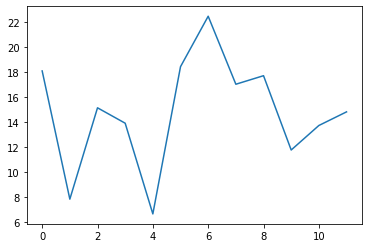

In [27]:
import matplotlib.pyplot as plt
vals = [18.113,7.863,15.165,13.934,6.683,18.453,22.484,17.049,17.731,11.792,13.751,14.84]
plt.plot(vals)